In [1]:
import os
import logging
import time
import requests
import re
import html
import random

from rag import Rag
from langchain_gigachat.chat_models import GigaChat
from requests.auth import HTTPBasicAuth
from langchain.tools import tool
from jira import JIRA 
from bs4 import BeautifulSoup as soup
from _config import credentials, login, token_jira, TOKEN
from urllib.parse import urlparse
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, SystemMessage

In [2]:
# === Инициализация модели GigaChat 
gigachat_model = GigaChat(
    credentials=credentials,
    verify_ssl_certs=False,
    timeout=360,
    temperature=0.18,
    top_p=0.3,
    model="GigaChat-2-Max"

)

In [3]:
class Memory:
    def __init__(self):
        self.data = {}

    def read(self, key):
        return self.data.get(key, "")

    def append(self, key, value):
        if key in self.data:
            self.data[key] += f"\n{value}"
        else:
            self.data[key] = value

    def clear(self):
        self.data = {}

In [4]:
memory_imp = Memory()

In [5]:
rag = Rag()

In [6]:
@tool
def data_loader(url_tz: str, url_code: str) -> str:
    """
    Скачивает код по ссылке (url_code) и бизнес требование по ссылке (url_tz) с конфлюенса.
    
    Args:
    url_tz: ссылка с требованиями на конфлюенсе str
    url_code: ссылка на код на конфлюенсе str
    return: Сообщение о статусе скачивания данных 
    """
    
    print("Начал скачивать данные!!!!!")
    # ТЗ
    match = re.search(r'/pages/(\d+)', url_tz)
    match_tz =  match.group(1) if match else None
    base_url = f"https://accergeev.atlassian.net/wiki/rest/api/content/{match_tz}?expand=body.storage"
    auth = HTTPBasicAuth(login, token_jira)
    if match_tz is not None:
        response = requests.get(base_url, auth=auth)
        if response.status_code == 200:
            data = response.json()
            project_requirements = soup(data['body']['storage']['value'], 'html.parser').get_text(separator="\n", strip=True)
            flag = False
        else:
            return f"Ошибка:, {response.status_code, response.text}"
    else:
        return 'В предоставленной ссылке для требований нет pageId.'
        
    # Проверяем ТЗ
    messages = [
    SystemMessage(
        content=""""Изучи следующий контекст шаг за шагом:\n
                1. Сначала внимательно прочитай предоставленный текст\n
                2. Проверь, является ли предоставленный текст бизнес требованием, а не кодом или просто случайным текстом. Бизнес требование имеет примерно такую структуру: формулирует, что должен делать разработчик, какие результаты ожидать и какие ограничения учитывать.\n
                3. Если предоставленный текст является бизнес требованием, то в итоговом ответе напиши - 'корректный формат требований', если нет, напиши - 'некорректный формат требований'"""
    ), HumanMessage(content=project_requirements)]
    time.sleep(1)
    req_checker = gigachat_model.invoke(messages)
    
    
    #Code
    match = re.search(r'/pages/(\d+)', url_code)
    match_code =  match.group(1) if match else None
    base_url = f"https://accergeev.atlassian.net/wiki/rest/api/content/{match_code}?expand=body.storage"
    if match_code is not None:
        response = requests.get(base_url, auth=auth)
        if response.status_code == 200:
            data = response.json()
            project_code = soup(data['body']['storage']['value'], 'html.parser').get_text(separator="\n", strip=True)
            flag = False
        else:
            return f"Ошибка:, {response.status_code, response.text}"
    else:
        return 'В предоставленной ссылке для кода нет pageId.'
        
        
    # Проверяем код    
    messages_code = [
    SystemMessage(
        content=""""Изучи следующий контекст шаг за шагом:
                1. Сначала внимательно прочитай предоставленный текст\n
                2. Проверь, является ли предоставленный текст кодом на Python, Java, SQL, C++ или Go, а не бизнес требованием или просто случайным текстом.\n
                3. Если предоставленный текст является кодом, то в итоговом ответе напиши - 'корректный формат кода', если нет, напиши - 'некорректный формат кода'"""
    ), HumanMessage(content=project_code)]
    time.sleep(1)
    code_checker = gigachat_model.invoke(messages_code) 
    
    if ('некорректный' in code_checker.content.lower()) or ('некорректный' in req_checker.content.lower()):
        asnwer = code_checker.content + '\n' + req_checker.content
        return asnwer
    else:
        memory_imp.append("Требования пользователя", project_requirements)
        memory_imp.append("Код пользователя", project_code)
        work_message = 'Данные загружены'
        return work_message

In [7]:
@tool
def data_loader_init(tz: str, code: str) -> str:
    """
    Сохраняет бизнес требование tz, которое передает пользователь, и код code
    
    tz: бизнес требование str
    code: код str
    return: Сообщение о получении данных 
    """
    # Проверяем ТЗ
    messages = [
    SystemMessage(
        content=""""Изучи следующий контекст шаг за шагом:\n
                1. Сначала внимательно прочитай предоставленный текст\n
                2. Проверь, является ли предоставленный текст бизнес требованием, а не кодом или просто случайным текстом. Бизнес требование имеет примерно такую структуру: формулирует, что должен делать разработчик, какие результаты ожидать и какие ограничения учитывать.\n
                3. Если предоставленный текст является бизнес требованием, то в итоговом ответе напиши - 'корректный формат требований', если нет, напиши - 'некорректный формат требований'"""
    ), HumanMessage(content=tz)]
    time.sleep(1)
    req_checker = gigachat_model.invoke(messages)
    
    # Проверяем код    
    messages_code = [
    SystemMessage(
        content=""""Изучи следующий контекст шаг за шагом:
                1. Сначала внимательно прочитай предоставленный текст\n
                2. Проверь, является ли предоставленный текст кодом на Python, Java, SQL, C++ или Go, а не бизнес требованием или просто случайным текстом.\n
                3. Если предоставленный текст является кодом, то в итоговом ответе напиши - 'корректный формат кода', если нет, напиши - 'некорректный формат кода'"""
    ), HumanMessage(content=code)]
    time.sleep(1)
    code_checker = gigachat_model.invoke(messages_code) 
    
    if ('некорректный' in code_checker.content.lower()) or ('некорректный' in req_checker.content.lower()):
        asnwer = code_checker.content + '\n' + req_checker.content
        return asnwer
    else:
        memory_imp.append("Требования пользователя", tz)
        memory_imp.append("Код пользователя", code)
        work_message = 'Данные загружены'
        return work_message

In [8]:
@tool
def req_analyzer(tz: str) -> str:
    """
    Анализирует текстовые требования tz и возвращает их анализ.
    
    tz: бизнес требование str
    return: Анализ требований str
    """
    print("Начал анализ требований!!!!!")
    if 'Требования пользователя' in memory_imp.data:
        message = memory_imp.read('Требования пользователя')
    else:
        message = tz
    data_rag = rag.get_data(message)
    rag_message = f'{message}\n{data_rag}'
    messages = [
    SystemMessage(
        content="""Задача: проанализировать текстовые требования на наличие логических ошибок, двусмысленных формулировок и противоречий.\n
        Выяви нечеткие определения, неопределённые числовые диапазоны, противоречивые условия, а также предложи рекомендации по их исправлению.\n
        Вывод должен содержать список обнаруженных проблем и рекомендации для корректировки требований.
        """
    ), HumanMessage(content=rag_message)]
    time.sleep(1)
    resp_req = gigachat_model.invoke(messages)
    memory_imp.append("Анализ требований", resp_req.content)
    
    return resp_req.content

In [9]:
@tool
def alignment_checker(code: str, tz: str) -> str:
    """ 
    Проверяет код пользователя code на соответсвие бизнес требованию tz и возвращает эту проверку.
    
    code: код пользователя str
    tz:  бизнес требование str
    return: Анализ соответсвия кода бизнес требованию str
    """
    print("Начал анализ соответствия!!!!!")
    if 'Требования пользователя' in memory_imp.data: 
        tz = memory_imp.read('Требования пользователя')
    if 'Код пользователя' in memory_imp.data: 
        code = memory_imp.read('Код пользователя') 
    combined_input = f"Требования:\n{code}\n\nКод:\n{tz}"
    messages_align = [
    SystemMessage(
        content=""" Задача: Сопоставить текстовые требования и исходный код, выявить несоответствия между задокументированным функционалом и реализованными возможностями.\n
                Важно: Если в требованиях описан функционал A, но в коде он отсутствует, это является несоответствием и должно быть указано.\n
                Если в коде присутствует функционал, который не указан в требованиях, это не является ошибкой, так как требования могут быть неполными.\n
                Обрати внимание на отсутствие задокументированных функций, несоответствие числовых диапазонов, а также нарушения архитектурных требований.\n
                Выведи отчет, в котором указаны: требования, которые не реализованы в коде, а также даны рекомендации по исправлению обнаруженных несоответствий.
        """
    ), HumanMessage(content=combined_input)]
    time.sleep(1)
    resp_alig = gigachat_model.invoke(messages_align)
    memory_imp.append("Анализ соответствий", resp_alig.content)
    return resp_alig.content

In [10]:
@tool
def coder_analyzer(code: str, tz: str) -> str:
    """ 
    Проверяет код пользователя code, учитывая бизнес требование tz, и возвращает его проверку.
    
    code: код пользователя str
    tz:  бизнес требование str
    return: проверка кода str
    """
    print("Начал анализ кода!!!!!")
    
    if 'Требования пользователя' in memory_imp.data: 
        tz = memory_imp.read('Требования пользователя')
    if 'Код пользователя' in memory_imp.data: 
        code = memory_imp.read('Код пользователя') 
    messages_сoder = [
    SystemMessage(
        content="""Ты умный помощник-программист, который должен генерировать надежный код строго по заданным требованиям. При работе необходимо соблюдать следующие принципы и правила:\n
                1. Анализ требований: Перед написанием кода внимательно проанализируй все документированные требования. Убедись, что полностью понял задачу, бизнес-логику и ожидаемый функционал.\n
                2. Полнота функционала: Реализуй весь указанный функционал без упущений. Ничего не пропускай – каждая деталь требований должна быть отражена в решении.\n
                3. Соответствие логике и ограничениям: Строго соблюдай бизнес-логику, математические формулы и все ограничения, указанные в требованиях. Решение должно точно соответствовать описанным правилам работы.\n
                4. В ответе верни только код.
        """
    ), HumanMessage(content=tz)]
    time.sleep(1)
    resp_coder = gigachat_model.invoke(messages_сoder)
    
    combined_code = f"Код пользователя:\n{code}\n\nКод LLM:\n{resp_coder.content}"
    two_code_analyzer = [
    SystemMessage(
        content="""Твоя задача – проанализировать два кода: один предоставлен LLM в качестве справочного бейзлайна, другой – код пользователя.\n
                Проведи тщательное сравнение с акцентом на математическую корректность реализации: убедись, что диапазоны, знаки в неравенствах и логические условия в коде пользователя полностью совпадают с кодом LLM.\n 
                Отличия в архитектуре, стиле или организации кода не являются ошибками и могут быть проигнорированы.\n 
                В итоговом ответе необходимо сформировать список расхождений, обнаруженных в коде пользователя по сравнению с кодом LLM.\n
                Код LLM предоставлен исключительно для справки – его комментировать не нужно. Если математическая логика в коде пользователя идентична, выведи сообщение об отсутствии расхождений.
        """
    ), HumanMessage(content=combined_code)]
    time.sleep(1)
    analyzer_coder = gigachat_model.invoke(two_code_analyzer)
    
    report_generator = [
        SystemMessage(
            content="""Задача: на основе сравнения кода пользователя и кода LLM напиши все обнаруженные ошибки в коде пользователя и рекомендации по их исправлению на том языке программирования, который использовал пользователь.\n
                Включи дополнительную информацию и подробности для каждого найденного пункта.\n
                Вывод должен быть структурированным и понятным для разработчиков и аналитиков.
                Не упоминай про код LLM и про другие версии кода в своем ответе."""
            ), HumanMessage(content=analyzer_coder.content)]
    report_generator_answer = gigachat_model.invoke(report_generator)
    memory_imp.append("Анализ кода", report_generator_answer.content)
            
    return report_generator_answer.content

In [11]:
@tool
def report_generator(code_data: str, alig_data: str, req_data: str) -> str:
    """ 
    Генерирует итоговый отчет о результате проверки по отчетам всех агентов
    
    code_data: отчет от анализатора кода str
    alig_data: отчет от анализатора соответствий str
    req_data: отчет от анализатора требований str
    return: итоговый отчет о результате проверки str
    """
    print("Генерирую отчет!!!!!")
    
    if 'Анализ кода' in memory_imp.data: 
        code_data = memory_imp.read('Анализ кода')
    if 'Анализ соответствий' in memory_imp.data: 
        alig_data = memory_imp.read('Анализ соответствий') 
    if 'Анализ требований' in memory_imp.data: 
        req_data = memory_imp.read('Анализ требований') 
    
    combined_analysis = f"""Результаты анализа требований:\n{req_data}\n
        Результаты анализа соответсвий:\n{alig_data}\n
        Результаты проверки кода пользователя:\n{code_data}\n"""
    messages_rep = [
    SystemMessage(
        content="""Задача: на основе отчетов, сформированного предыдущими агентами, выделить только самые серьезные ошибки и недочеты.\n
                 Сформируй суммаризованный отчет, который должен содержать три части, строго в следующей структуре:\n\n
                  Отчет по требованиям:\n
                 *Отчет по требованиям*\n\n
                  Отчет соответствия требований и кода:\n
                 *Отчет по коду*\n\n
                 В раздел \"Отчет по требованиям\" включи самые критичные проблемы из анализа требований,
                 в раздел \"Отчет по коду\" – наиболее существенные несоответствия между требованиями и кодом
        """
    ), HumanMessage(content=combined_analysis)]
    time.sleep(1)
    fin_answer = gigachat_model.invoke(messages_rep)
    memory_imp.append("Финальный отчет", fin_answer.content)
    return fin_answer.content

In [12]:
@tool
def send_document_confluence(link: str) -> str:
    """
    Отправляет финальный отчет в Confluence по ссылке link
    
    link: ссылка на confluence str
    return сообшение об отправке
    """
    # URL для создания комментария
    url = "https://accergeev.atlassian.net/wiki/rest/api/content"
    # Заголовки
    headers = {
        "Content-Type": "application/json"
    }
    
    
    final_report = memory_imp.read("Финальный отчет")
    
    match = re.search(r'/pages/(\d+)', link)
    PAGE_ID = match.group(1)
    # Тело запроса
    data = {
        "type": "comment",
        "container": {
            "id": PAGE_ID,
            "type": "page"
        },
        "body": {
            "storage": {
                "value": html.escape(f"{final_report}"),
                "representation": "storage"
            }
        }
    }
    auth = HTTPBasicAuth(login, token_jira) 

    # Отправка запроса
    response = requests.post(url, auth=auth, headers=headers, json=data)

    return "Комментарий оставлен!"

In [13]:
@tool
def create_jira_task(link: str, summary: str, description: str) -> str:
    """
    Создает задачу в Jira по ссылке link c заголовком summary и описанием description и возвращает её ключ.

    link: ссылка на Jira str
    summary: заголовок задачи str
    description: описание задачи str
    return: ключ задачи Jira
    """
    
    match = re.search(r'/projects/([A-Z0-9]+)', link)
    project_key = match.group(1)
    server_name = urlparse(link).netloc
    jira_options = {'server': f'https://{server_name}'}
    jira = JIRA(options=jira_options, basic_auth=(login, token_jira))

    new_issue = jira.create_issue(
                project=project_key,
                summary=summary,
                description=description,
                issuetype={"name": 'Task'})
    return f"Задача создана {new_issue.key}"

In [ ]:
tools = [req_analyzer, coder_analyzer, alignment_checker, report_generator, data_loader_init, data_loader, send_document_confluence] #create_jira_task]

In [15]:
ll_with_tools = gigachat_model.bind_tools(tools)

In [16]:
def tool_calling_llm(state: MessagesState):
    promt_cesar = [
    SystemMessage(
        content="""Ты асистент, который проверяет бизнес-требования и код, а также их соответствие друг другу.\n 
Твоя задача рассказать пользователю, что ты умеешь. Обязательно скажи, что для работы в тебя надо загрузить данные, можно по ссылкам на конфлюенс, а можно текстом\n
Если тебе не хватает каких-то данных, запрашивай их у пользователя.\n
""" 
    )] + state["messages"]
    return {"messages": [ll_with_tools.invoke(promt_cesar)]}

In [17]:
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

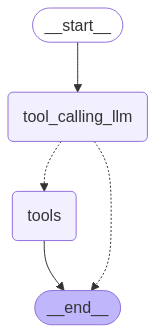

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
def chat(thread_id: str):
    config_ = {"configurable": {"thread_id": thread_id}}
    while(True):
        rq = input("")
        if rq == "":
            break
        resp = graph.invoke({"messages": rq}, config=config_)
        print("Assistant: ", resp["messages"][-1].content)
        time.sleep(1) # For notebook capability

chat("22")

Assistant:  Привет! Я могу помочь тебе проверить бизнес-требования и код на соответствие друг другу. Вот основные функции, которые я выполняю:
- **Анализирую** текстовые бизнес-требования;
- Проверяю **соответствие кода требованиям**;
- Могу скачать данные из Confluence или принять их от тебя напрямую через текст.

Чтобы начать работу, мне нужно получить либо ссылки на документы с требованиями и кодом, либо сам текст этих документов. Если есть какие-либо вопросы или нужна помощь — обращайся!

Какую задачу будем решать?


### TG Реализация

In [ ]:
import asyncio
import logging
from aiogram import Bot, Dispatcher, types
from aiogram.types import Message, InlineKeyboardMarkup, InlineKeyboardButton, CallbackQuery, FSInputFile
from aiogram.filters import Command
from aiogram.enums import ParseMode
from aiogram.client.default import DefaultBotProperties
from aiogram.fsm.context import FSMContext
from aiogram.fsm.state import StatesGroup, State
from aiogram.types import FSInputFile


thread_id = random.randint(1, 1000)
сonfig_ = {"configurable": {"thread_id": f'{thread_id}'}}

# Инициализация бота и диспетчера
bot = Bot(token=TOKEN, default=DefaultBotProperties(parse_mode=ParseMode.HTML))
dp = Dispatcher()

# Определяем состояния для диалога
class InsuranceState(StatesGroup):
    waiting_for_user = State()

# Функция для создания клавиатуры с кнопками
def get_main_keyboard():
    return InlineKeyboardMarkup(
        inline_keyboard=[
            [InlineKeyboardButton(text="🧑‍💼 Запуск GiGA-Цезарь", callback_data="сaesar")],
        ]
    )


# Обработчик команды /start (показывает кнопки)
@dp.message(Command("start"))
async def start_handler(message: Message):
    await message.answer("👋 Привет! Чтобы запустить GiGA-Цезаря, нажми на кнопку:", reply_markup=get_main_keyboard())

    
# Обработчик нажатия кнопки "Остановить диалог"
@dp.message(Command("stop"))
async def stop_dialog(message: Message, state: FSMContext):
    global сonfig_
    memory_imp.clear()
    thread_id = random.randint(1, 1000)
    сonfig_ = {"configurable": {"thread_id": f'{thread_id}'}}
    await message.answer("Диалог завершен. Чтобы начать снова, используйте кнопку 'Перезапустить систему'.", reply_markup=None)
    await state.clear()  # Очищаем состояние

    
# Обработчик нажатия кнопки "Перезапустить бота"
@dp.message(Command("restart"))
async def restart_bot(message: Message, state: FSMContext):
    global сonfig_
    memory_imp.clear()
    thread_id = random.randint(1, 1000)
    сonfig_ = {"configurable": {"thread_id": f'{thread_id}'}}
    await message.answer("Система перезапущена. Выберите действие:", reply_markup=get_main_keyboard())
    await state.clear()  # Сбрасываем состояние
    
    
# Обработчик нажатия кнопки "Запуск GiGA-Цезарь"
@dp.callback_query(lambda c: c.data == "сaesar")
async def insurance_consultant(callback: CallbackQuery, state: FSMContext):
    await callback.message.answer("GiGA-Цезарь запущен!")
    await state.set_state(InsuranceState.waiting_for_user)
    await callback.answer()  # Закрываем "часики" на кнопке
    
    

# Обработчик ввода от пользователя после выбора "GiGA-Цезарь"
@dp.message(InsuranceState.waiting_for_user)
async def process_consultant_message(message: Message, state: FSMContext):
    user_text = message.text
    resp = graph.invoke({"messages": user_text}, config=сonfig_)
    try:
        time.sleep(1)
        await message.answer(resp["messages"][-1].content)
    except:
        with open('answer_agent.txt', 'w', encoding="utf-8") as f:
            f.write(resp["messages"][-1].content)
            time.sleep(1)
        await message.answer_document(document=FSInputFile('answer_agent.txt'))

async def main():
    logging.basicConfig(level=logging.INFO)
    await dp.start_polling(bot, skip_updates=True)
    

loop = asyncio.get_running_loop()
loop.create_task(main())  # Запускаем main() без блокировки цикла

<Task pending name='Task-5' coro=<main() running at /var/folders/6j/f0vg68hn36q74_37dv0v8vg40000gn/T/ipykernel_57862/1680615418.py:84>>

INFO:aiogram.dispatcher:Start polling
INFO:aiogram.dispatcher:Run polling for bot @GiGACesBot id=7595969817 - 'GiGA-Цезарь_V2'
INFO:aiogram.event:Update id=428534717 is handled. Duration 374 ms by bot id=7595969817
INFO:aiogram.event:Update id=428534718 is handled. Duration 269 ms by bot id=7595969817
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 500 Internal Server Error"
INFO:aiogram.event:Update id=428534719 is not handled. Duration 1151 ms by bot id=7595969817
ERROR:aiogram.event:Cause exception while process update id=428534719 by bot id=7595969817
ResponseError: (URL('https://gigachat.devices.sberbank.ru/api/v1/chat/completions'), 500, b'{"status":500,"message":"Internal Server Error"}\n', Headers({'server': 'SynGX', 'date': 'Fri, 04 Apr 2025 08:53:38 GMT', 'content-type': 'application/json; charset=utf-8', 'content-length': '49'